# Generation of hyperspectral samples using Wasserstein-GANs

Wasserstein-GANs are Generative Adversarial Models that can be used to generate synthetic data that approximates a specific input distribution of real data.

In this notebook, we show how to use such a tool to generate *ex nihilo* synthetic hyperspectral samples.

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch
torch.cuda.is_available()

True

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.utils.data
from scipy.io import loadmat
from skimage import io
from PIL import Image


We load the Pavia University dataset. The `.mat` files are available on [this website](http://www.ehu.eus/ccwintco/index.php?title=Hyperspectral_Remote_Sensing_Scenes).

In [3]:
# img = loadmat('./PaviaU.mat')['paviaU']
# gt = loadmat('./PaviaU_gt.mat')['paviaU_gt']
# mask = np.random.randint(0, 100, gt.shape) < 5
# train_gt = np.copy(gt)
# train_gt[np.nonzero(~mask)] = 0
# test_gt = np.copy(gt)
# test_gt[train_gt > 0] = 0
# rgb = img[:,:,(55,41,12)]
# rgb = (255 * (rgb.astype(np.float32) - rgb.min())/(rgb.max() - rgb.min())).astype(np.uint8)
# print(np.shape(img))
# print(np.shape(gt))
# print(np.shape(train_gt))
# print(np.shape(rgb))

(610, 340, 103)
(610, 340)
(610, 340)
(610, 340, 3)


In [17]:
# print(img[0][0])
# print(img[img > 1])
counts = np.asarray(np.unique(gt,return_counts=True))
print(counts)

[1848 2257 1925 ... 8015 7676 4485]
[[     1      2      4      5]
 [ 52011  48739 106543    107]]


In [ ]:

# gt =  np.rot90(gt,1,(0,1))

# classes = np.array([
#     [153 ,  0 ,  0], #unspecified
#     [  0 ,  0 ,255], #roads
#     [  0, 255 ,  0], #vegetation
#     [  0 ,255 ,255], #water
#     [255 ,  0 ,0],#buidings 
#     [255 ,127 , 80]#cars
# ])
# # d = {
# #     repr([153 ,  0 ,  0]): 0,
# #     repr([0 ,  0 ,255]): 1,
# #     repr([ 0, 255 ,  0]): 2,
# #     repr([ 0 ,255 ,255]): 3,
# #     repr([255 ,  0 ,0]): 4,
# #     repr([255 ,127 , 80]): 5,
# # }
# gt_temp = np.zeros((gt.shape[0],gt.shape[1]))

# for i in range(gt.shape[0]):
#     for j in range(gt.shape[1]):
#         val = gt[i][j]
#         for id in range(len(classes)):
#             if np.array_equal(val, classes[id]):
#                 gt_temp[i][j] = id
        
        
# gt = gt_temp        
# gt_new = Image.fromarray(gt)
# gt_new.save('gt_new.tif')

In [45]:
# img = io.imread('C:\\Users\\golde\\Documents\\GitHub\\AeroRIT\\Aerial Data\\Collection\\image_hsi_radiance.tif')
# img_rgb = io.imread('C:\\Users\\golde\\Documents\\GitHub\\AeroRIT\\Aerial Data\\Collection\\image_rgb.tif')
img = io.imread('E:\\Accessories\\Documents\\Python Scripts\\AeroRIT\\Aerial Data\\Collection\\image_hsi_radiance.tif')
img_rgb = io.imread('E:\\Accessories\\Documents\\Python Scripts\\AeroRIT\\Aerial Data\\Collection\\image_rgb.tif')
# E:\Accessories\Documents\Python Scripts\AeroRIT\Aerial Data
# gt = io.imread('C:\\Users\\golde\\Documents\\GitHub\\AeroRIT\\Aerial Data\\Collection\\image_labels.tif')
gt = io.imread('./gt_new.tif')
gt = gt.astype(int)

img = np.rot90(img,1,(0,2))
img_rgb =  np.rot90(img_rgb,1,(0,1))

# crop images
crop_offset = 348
crop_w = 610*2 + crop_offset
crop_h = 340*2 + crop_offset

img = img[crop_offset:crop_w,crop_offset:crop_h,:]
img_rgb = img_rgb[crop_offset:crop_w,crop_offset:crop_h,:]
gt = gt[crop_offset:crop_w,crop_offset:crop_h]
# img = img[:3974,:1972,:]
# img_rgb = img_rgb[:3974,:1972,:]
# gt = gt[:3974,:1972]
counts = np.asarray(np.unique(gt,return_counts=True))
print(counts)
print(np.shape(img))
print(np.shape(img_rgb))
print(gt.shape)

mask = np.random.randint(0, 100, gt.shape) < 5
train_gt = np.copy(gt)
train_gt[np.nonzero(~mask)] = 0
test_gt = np.copy(gt)
test_gt[train_gt > 0] = 0
rgb = img_rgb
rgb = (255 * (rgb.astype(np.float32) - rgb.min())/(rgb.max() - rgb.min())).astype(np.uint8)
print(np.shape(img))
print(np.shape(gt))
print(np.shape(train_gt))
print(np.shape(rgb))




[[     0      1      2      3      4      5]
 [  1446 245740 465426   5164 101880   9944]]
(1220, 680, 51)
(1220, 680, 3)
(1220, 680)
(1220, 680, 51)
(1220, 680)
(1220, 680)
(1220, 680, 3)


The ground truth is shown below. We sample 10% from the pixels as training samples.

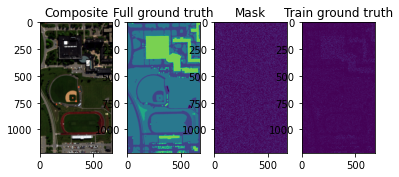

In [47]:
fig = plt.figure()
fig.add_subplot(141)
plt.imshow(rgb)
plt.title("Composite")
fig.add_subplot(142)
plt.imshow(gt)
plt.title("Full ground truth")
fig.add_subplot(143)
plt.imshow(mask)

plt.title("Mask")
fig.add_subplot(144)
plt.imshow(train_gt)
plt.title("Train ground truth")
plt.show()

We define a `HyperX` class to hold the dataset. Note that the label is encoded as a one-hot vector.

In [48]:
from skimage import morphology

class HyperX(torch.utils.data.Dataset):
    
    def __init__(self, data, ground_truth, semi=False):
        super(HyperX, self).__init__()
        # print('init dataloader')
        # Normalize the data in [0,1]
        data = (data - data.min()) / (data.max() - data.min())
        self.data = data
        self.gt = ground_truth
        self.n_classes = len(np.unique(ground_truth))
        if semi:
            # Semi-supervision, include neighbours at 50px
            x_pos, y_pos = np.nonzero(morphology.dilation(ground_truth > 0, morphology.disk(50)))
        else:
            x_pos, y_pos = np.nonzero(ground_truth)
        self.indices = [idx for idx in zip(x_pos, y_pos)]
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, i):
        x, y = self.indices[i]
        data = self.data[x,y]
        # Get the label in one-hot encoded style
        # print(self.n_classes,x, y,np.eye(self.n_classes),self.gt[x, y])
        label = np.asarray(np.eye(self.n_classes)[self.gt[x, y]], dtype='int64')
        return torch.from_numpy(data), torch.from_numpy(label)

In [49]:
import os
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

# Basic generator that maps: noise + condition -> fake samples
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # LeakyReLU is preferred to keep gradients flowing even for negative activations
        self.generator = torch.nn.Sequential(
            torch.nn.Linear(z_dim + c_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, X_dim),
            torch.nn.Sigmoid() # smooth [0,1] outputs
        )
        self.apply(weight_init)

    def forward(self, z, c):
        # Concatenate the noise and condition
        inputs = torch.cat([z, c], 1)
        return self.generator(inputs)

# Basic fully connected discriminator: sample -> -infty -- fake - 0 - real -- +infty
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = torch.nn.Sequential(
            torch.nn.Linear(X_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, 1)
        )
        
        self.apply(weight_init)

    def forward(self, X):
        return self.discriminator(X)

# Basic fully connected classifier: sample -> class
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.discriminator = torch.nn.Sequential(
            torch.nn.Linear(X_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, c_dim)
        )
        
        self.apply(weight_init)

    def forward(self, X):
        return self.discriminator(X)

In [50]:
mb_size = 256 # Batch size
z_dim = 30   # Noise dimension
X_dim = img.shape[-1] # Number of bands
print(X_dim)
h_dim = 512  # Hidden layer size
d_step = 5   # Number of discriminator training steps for ea ch generator training step
lr = 5e-5    # Learning rate
c_weight = 0.2 # Auxiliary classifier weight
flip_percentage = 0.0 # Proportion of label flipping
mixup_alpha = 0.1 # Mixup
semi_supervised = True # semi-supervision (set to True to include unlabeled samples)

# Build the dataset and data loader
data_loader = torch.utils.data.DataLoader(
    HyperX(img, train_gt if semi_supervised else gt), batch_size=mb_size, shuffle=True)
# c_dim = condition vector size
c_dim = data_loader.dataset.n_classes
print(c_dim)
# Ignore the class 0
class_weights = torch.ones((c_dim))
class_weights[0] = 0.
class_weights = class_weights.cuda()

51
6


In [51]:
# Initialize weights using the He et al. (2015) policy.
def weight_init(m):
    if isinstance(m, (nn.Linear, nn.Conv2d, nn.Conv3d, nn.ConvTranspose3d)):
        torch.nn.init.kaiming_normal_(m.weight.data)

# Spherical interpolation between two vectors on the unit hypersphere
# See : https://github.com/soumith/dcgan.torch/issues/14
def slerp(val, low, high):
    omega = np.arccos(np.clip(np.dot(low/np.linalg.norm(low), high/np.linalg.norm(high)), -1, 1))
    so = np.sin(omega)
    if so == 0:
        return (1.0-val) * low + val * high # L'Hopital's rule/LERP
    return np.sin((1.0-val)*omega) / so * low + np.sin(val*omega) / so * high

def lerp(val, low, high):
    return (1.0-val) * low + val * high # L'Hopital's rule/LERP

# Gradient penalty from the Improved WGAN training
# From : https://github.com/EmilienDupont/wgan-gp
# Use penalty_weight set at 10, as suggested in the paper
def calc_gradient_penalty(netD, real_data, generated_data, penalty_weight=10):
        batch_size = real_data.size()[0]

        alpha = torch.rand(batch_size, 1) if real_data.dim() == 2 else torch.rand(batch_size, 1, 1, 1)
        alpha = alpha.expand_as(real_data)
        alpha = alpha.cuda()
        
        interpolated = alpha * real_data + (1 - alpha) * generated_data
        #interpolated = Variable(interpolated, requires_grad=True)
        interpolated.requires_grad_()
        interpolated = interpolated.cuda()

        # Calculate probability of interpolated examples
        prob_interpolated = netD(interpolated)

        # Calculate gradients of probabilities with respect to examples
        gradients = torch.autograd.grad(outputs=prob_interpolated, inputs=interpolated,
                               grad_outputs=torch.ones(prob_interpolated.size()).cuda(),
                               create_graph=True, retain_graph=True)[0]

        # Gradients have shape (batch_size, num_channels, img_width, img_height),
        # so flatten to easily take norm per example in batch
        gradients = gradients.view(batch_size, -1)

        # Derivatives of the gradient close to 0 can cause problems because of
        # the square root, so manually calculate norm and add epsilon
        gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

        # Return gradient penalty
        return penalty_weight * ((gradients_norm - 1) ** 2).mean()
    
def reset_grad(*nets):
    for net in nets:
        net.zero_grad()
        
def plot_mean_std(samples):
    mean_spectrum = np.mean(samples, axis=0)
    std_spectrum = np.std(samples, axis=0)
    plt.plot(mean_spectrum - std_spectrum, linestyle='dotted', label='-std')
    plt.plot(mean_spectrum, label='mean')
    plt.plot(mean_spectrum + std_spectrum, linestyle='dotted', label='+std')

  0%|          | 0/100000 [00:00<?, ?it/s]c:\Users\nang\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Iter-0; D_loss: -2.2966089248657227; G_loss: 3.0633182525634766; C_loss: 1.208816647529602


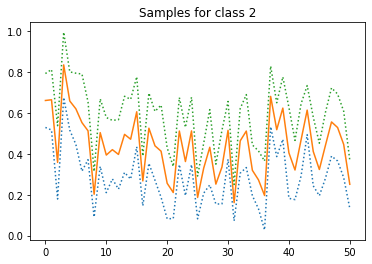

  1%|          | 1000/100000 [01:47<3:00:01,  9.17it/s]

Iter-1000; D_loss: -0.10021184384822845; G_loss: -0.3913061022758484; C_loss: 0.08926606923341751


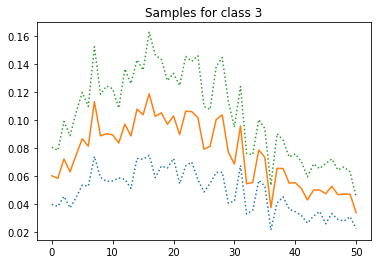

  2%|▏         | 2000/100000 [03:31<2:43:15, 10.00it/s]

Iter-2000; D_loss: -0.06810879707336426; G_loss: -0.3425337076187134; C_loss: 0.04525898024439812


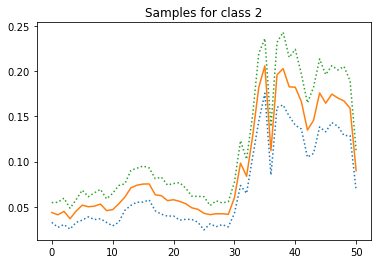

  3%|▎         | 3000/100000 [05:15<2:51:54,  9.40it/s]

Iter-3000; D_loss: -0.046490587294101715; G_loss: -0.2860758304595947; C_loss: 0.04326576739549637


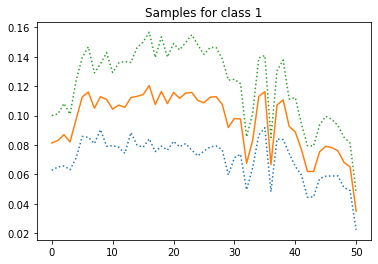

  4%|▍         | 4000/100000 [07:00<2:50:46,  9.37it/s]

Iter-4000; D_loss: -0.036906540393829346; G_loss: -0.23680844902992249; C_loss: 0.03414788842201233


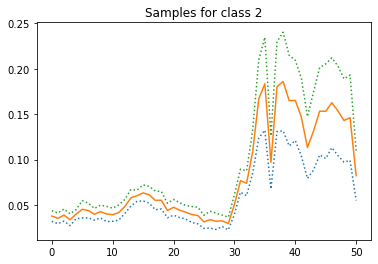

  5%|▌         | 5000/100000 [08:45<2:45:29,  9.57it/s]

Iter-5000; D_loss: -0.018114211037755013; G_loss: -0.2109459638595581; C_loss: 0.02333463728427887


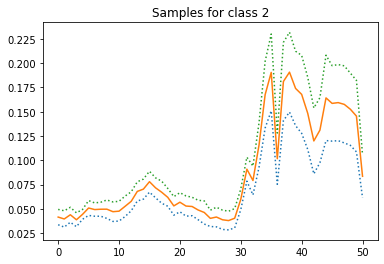

  6%|▌         | 5999/100000 [10:31<2:40:29,  9.76it/s]

Iter-6000; D_loss: -0.016601432114839554; G_loss: -0.21382910013198853; C_loss: 0.05469309166073799


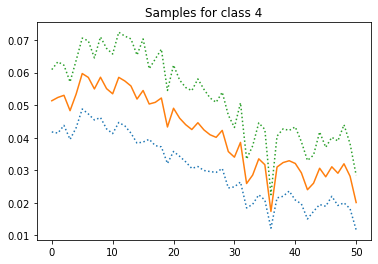

  7%|▋         | 6999/100000 [12:16<2:50:08,  9.11it/s]

Iter-7000; D_loss: -0.009290029294788837; G_loss: -0.22656367719173431; C_loss: 0.02418753132224083


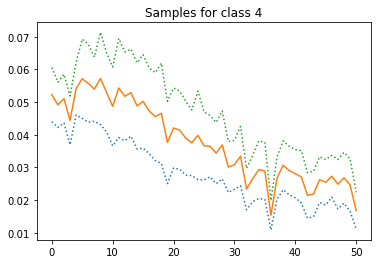

  8%|▊         | 8000/100000 [14:02<3:02:36,  8.40it/s]

Iter-8000; D_loss: -0.010495541617274284; G_loss: -0.24448993802070618; C_loss: 0.022475922480225563


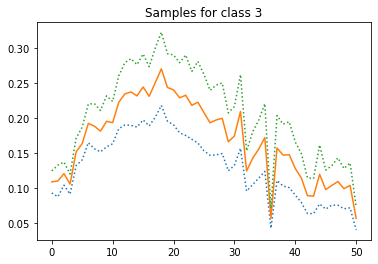

  9%|▉         | 8999/100000 [15:48<2:42:47,  9.32it/s]

Iter-9000; D_loss: -0.010205810889601707; G_loss: -0.25056973099708557; C_loss: 0.018827548250555992


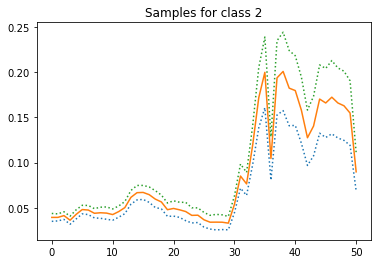

 10%|▉         | 9999/100000 [17:34<2:29:55, 10.01it/s]

Iter-10000; D_loss: -0.013967828825116158; G_loss: -0.25137728452682495; C_loss: 0.02611812949180603


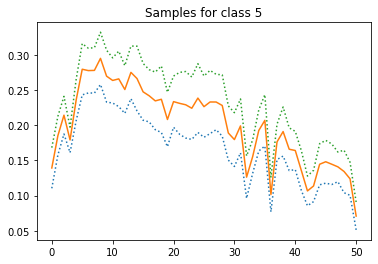

 11%|█         | 11000/100000 [19:20<2:33:37,  9.66it/s]

Iter-11000; D_loss: -0.00879282969981432; G_loss: -0.255837619304657; C_loss: 0.042044613510370255


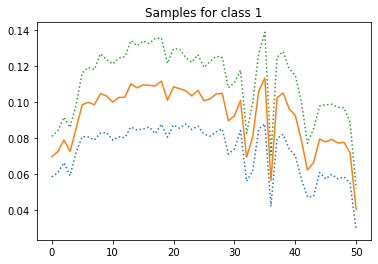

 12%|█▏        | 12000/100000 [21:06<2:37:14,  9.33it/s]

Iter-12000; D_loss: -0.0031221378594636917; G_loss: -0.26396697759628296; C_loss: 0.020916728302836418


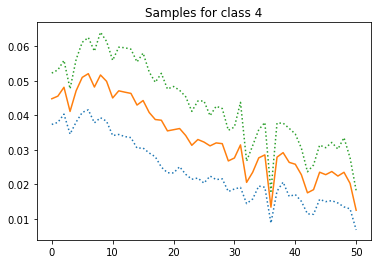

 13%|█▎        | 12999/100000 [22:52<2:32:49,  9.49it/s]

Iter-13000; D_loss: -0.009115093387663364; G_loss: -0.2546360492706299; C_loss: 0.016712190583348274


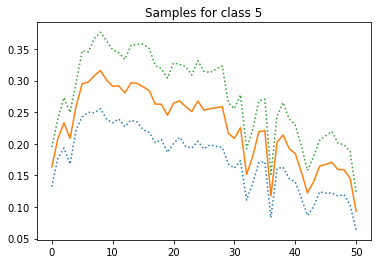

 14%|█▍        | 13999/100000 [24:37<2:23:34,  9.98it/s]

Iter-14000; D_loss: -0.008450379595160484; G_loss: -0.2587875723838806; C_loss: 0.029379744082689285


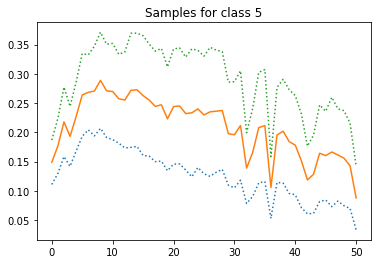

 15%|█▌        | 15000/100000 [26:23<2:36:10,  9.07it/s]

Iter-15000; D_loss: -0.002426563296467066; G_loss: -0.24829643964767456; C_loss: 0.02990856021642685


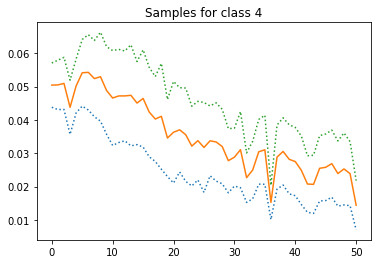

 16%|█▌        | 16000/100000 [28:09<2:33:24,  9.13it/s]

Iter-16000; D_loss: -0.005409295205026865; G_loss: -0.25019314885139465; C_loss: 0.020653778687119484


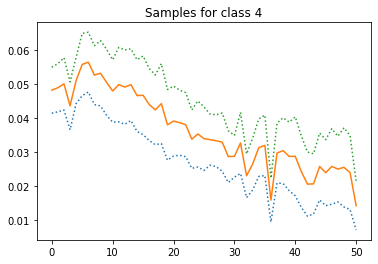

 17%|█▋        | 16999/100000 [29:54<2:19:04,  9.95it/s]

Iter-17000; D_loss: -0.015529213473200798; G_loss: -0.24295184016227722; C_loss: 0.0286090187728405


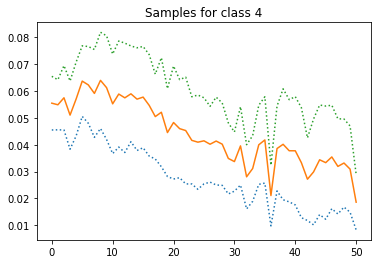

 18%|█▊        | 18000/100000 [31:40<2:20:47,  9.71it/s]

Iter-18000; D_loss: -0.008380339480936527; G_loss: -0.23264679312705994; C_loss: 0.02327013574540615


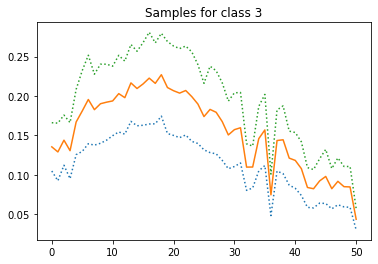

 19%|█▉        | 19000/100000 [33:25<2:14:13, 10.06it/s]

Iter-19000; D_loss: -0.003970643971115351; G_loss: -0.23496901988983154; C_loss: 0.01582740992307663


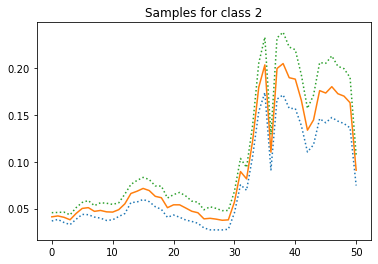

 20%|██        | 20000/100000 [35:11<2:24:33,  9.22it/s]

Iter-20000; D_loss: -0.006687353365123272; G_loss: -0.23691414296627045; C_loss: 0.026709917932748795


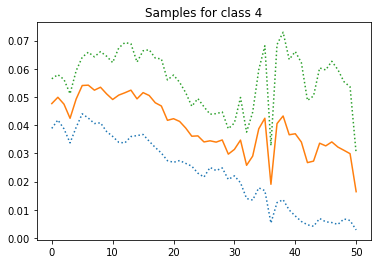

 21%|██        | 21000/100000 [36:55<2:13:07,  9.89it/s]

Iter-21000; D_loss: -0.003318201517686248; G_loss: -0.24147552251815796; C_loss: 0.019372569397091866


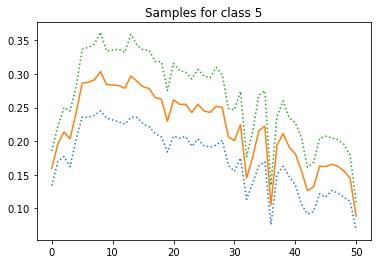

 22%|██▏       | 22000/100000 [38:39<2:14:03,  9.70it/s]

Iter-22000; D_loss: -0.004687044769525528; G_loss: -0.2319081425666809; C_loss: 0.019920136779546738


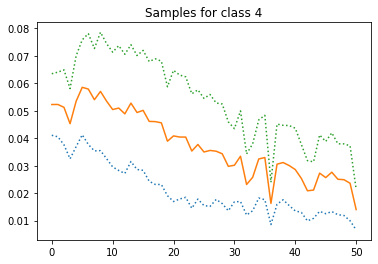

 23%|██▎       | 23000/100000 [40:23<2:21:56,  9.04it/s]

Iter-23000; D_loss: -0.010137909092009068; G_loss: -0.22609466314315796; C_loss: 0.02895478904247284


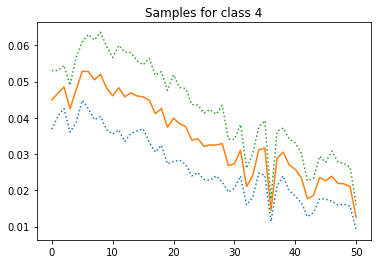

 24%|██▍       | 24000/100000 [42:08<2:16:08,  9.30it/s]

Iter-24000; D_loss: -0.006199835799634457; G_loss: -0.22790437936782837; C_loss: 0.018697069957852364


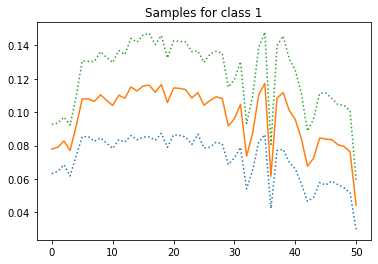

 25%|██▍       | 24999/100000 [43:53<2:07:06,  9.83it/s]

Iter-25000; D_loss: -0.00658490601927042; G_loss: -0.21990233659744263; C_loss: 0.020240316167473793


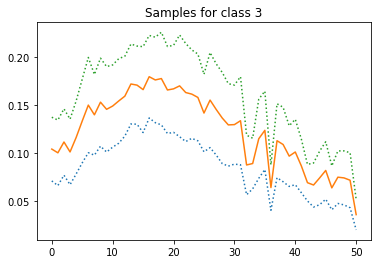

 26%|██▌       | 25999/100000 [45:36<2:06:12,  9.77it/s]

Iter-26000; D_loss: -0.0027639176696538925; G_loss: -0.21963796019554138; C_loss: 0.02221336029469967


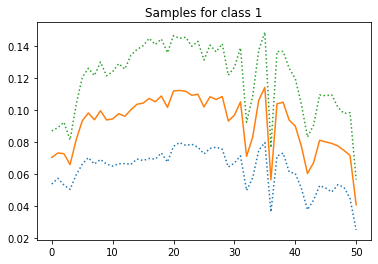

 27%|██▋       | 27000/100000 [47:20<2:06:21,  9.63it/s]

Iter-27000; D_loss: -0.004618518054485321; G_loss: -0.2188682109117508; C_loss: 0.016056541353464127


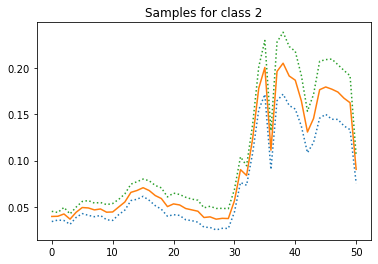

 28%|██▊       | 28000/100000 [49:05<2:11:13,  9.14it/s]

Iter-28000; D_loss: -0.00981302559375763; G_loss: -0.21138280630111694; C_loss: 0.027208007872104645


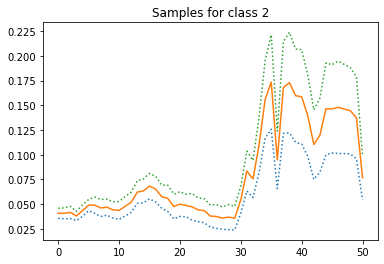

 29%|██▉       | 29000/100000 [50:51<2:08:50,  9.18it/s]

Iter-29000; D_loss: -0.012349573895335197; G_loss: -0.21680039167404175; C_loss: 0.02601933479309082


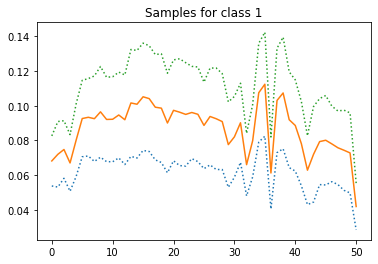

 30%|██▉       | 29999/100000 [52:36<2:10:04,  8.97it/s]

Iter-30000; D_loss: -0.004575226455926895; G_loss: -0.21741114556789398; C_loss: 0.01620057411491871


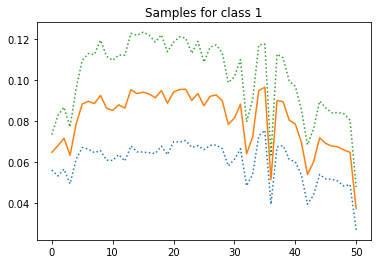

 31%|███       | 31000/100000 [54:22<2:15:31,  8.49it/s]

Iter-31000; D_loss: -0.0017303623026236892; G_loss: -0.225607767701149; C_loss: 0.01325199194252491


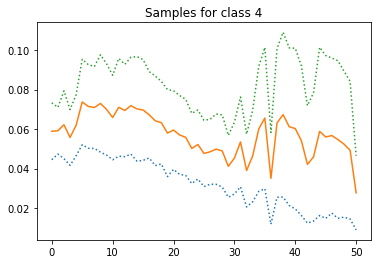

 32%|███▏      | 32000/100000 [56:08<2:01:29,  9.33it/s]

Iter-32000; D_loss: -0.0024675829336047173; G_loss: -0.2200535535812378; C_loss: 0.01829059235751629


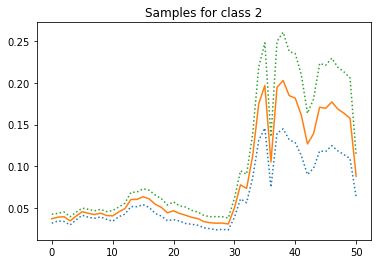

 33%|███▎      | 32999/100000 [57:54<1:56:04,  9.62it/s]

Iter-33000; D_loss: 0.0012437873519957066; G_loss: -0.22288501262664795; C_loss: 0.011331572197377682


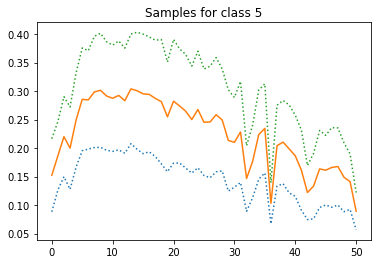

 34%|███▍      | 33999/100000 [59:41<1:49:01, 10.09it/s]

Iter-34000; D_loss: -0.012892098166048527; G_loss: -0.21869805455207825; C_loss: 0.017449183389544487


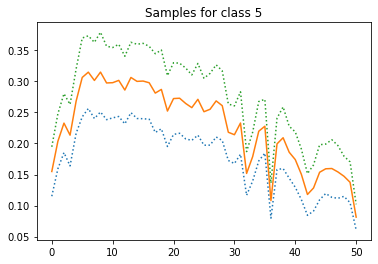

 35%|███▌      | 35000/100000 [1:01:27<1:49:38,  9.88it/s]

Iter-35000; D_loss: -0.003218388883396983; G_loss: -0.22448110580444336; C_loss: 0.012015367858111858


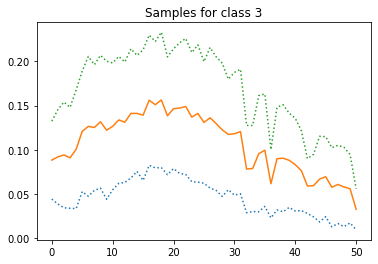

 36%|███▌      | 36000/100000 [1:03:13<1:47:44,  9.90it/s]

Iter-36000; D_loss: -0.0053828321397304535; G_loss: -0.2208874672651291; C_loss: 0.015867164358496666


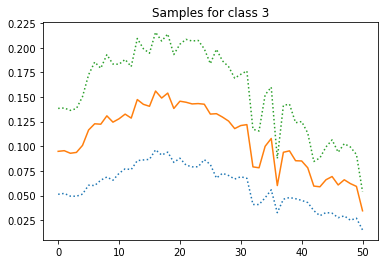

 37%|███▋      | 37000/100000 [1:05:00<1:54:25,  9.18it/s]

Iter-37000; D_loss: 0.00038185063749551773; G_loss: -0.21593405306339264; C_loss: 0.015367917716503143


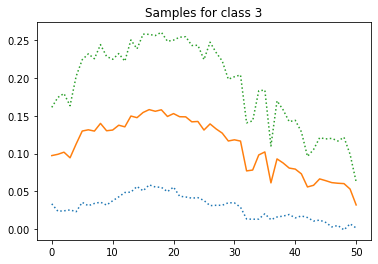

 38%|███▊      | 38000/100000 [1:06:46<1:43:17, 10.00it/s]

Iter-38000; D_loss: -0.0031168111599981785; G_loss: -0.22222353518009186; C_loss: 0.01880616508424282


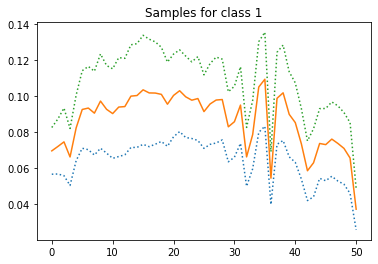

 39%|███▉      | 39000/100000 [1:08:32<1:48:03,  9.41it/s]

Iter-39000; D_loss: -0.002164394361898303; G_loss: -0.22494880855083466; C_loss: 0.009669696912169456


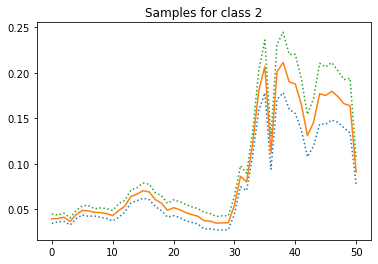

 40%|████      | 40000/100000 [1:10:19<1:47:54,  9.27it/s]

Iter-40000; D_loss: -0.003082888200879097; G_loss: -0.21762919425964355; C_loss: 0.01206206250935793


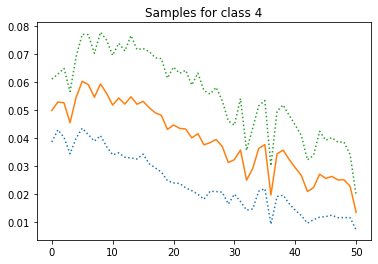

 41%|████      | 41000/100000 [1:12:07<1:42:37,  9.58it/s]

Iter-41000; D_loss: -0.002340857870876789; G_loss: -0.22045351564884186; C_loss: 0.01308023277670145


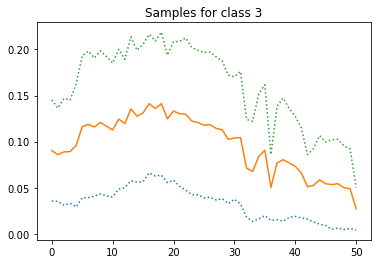

 42%|████▏     | 42000/100000 [1:13:53<1:38:31,  9.81it/s]

Iter-42000; D_loss: -0.010355010628700256; G_loss: -0.22413185238838196; C_loss: 0.015580721199512482


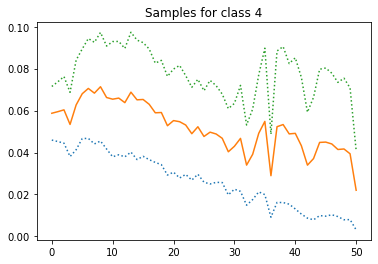

 43%|████▎     | 42999/100000 [1:15:41<1:35:36,  9.94it/s]

Iter-43000; D_loss: -0.003215082222595811; G_loss: -0.22605794668197632; C_loss: 0.014849957078695297


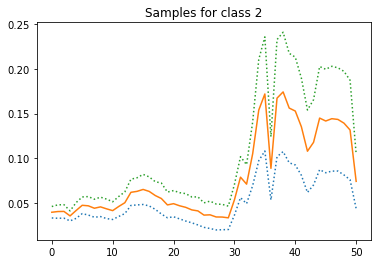

 44%|████▍     | 44000/100000 [1:17:29<1:40:42,  9.27it/s]

Iter-44000; D_loss: -0.008069809526205063; G_loss: -0.2179126888513565; C_loss: 0.012626295909285545


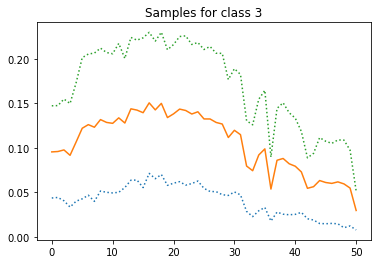

 45%|████▌     | 45000/100000 [1:19:17<1:40:38,  9.11it/s]

Iter-45000; D_loss: -0.0005184076726436615; G_loss: -0.2273252010345459; C_loss: 0.010378973558545113


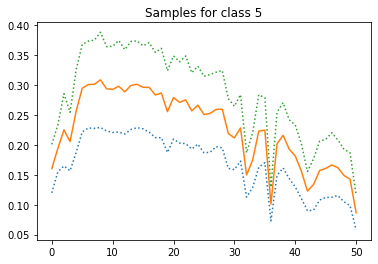

 46%|████▌     | 46000/100000 [1:21:05<1:30:45,  9.92it/s]

Iter-46000; D_loss: -0.006007716059684753; G_loss: -0.22404542565345764; C_loss: 0.014334222301840782


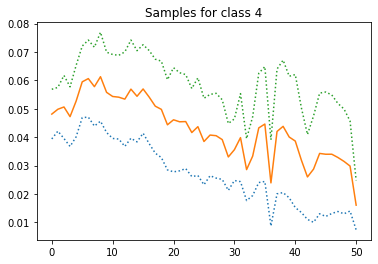

 47%|████▋     | 46999/100000 [1:22:51<1:27:20, 10.11it/s]

Iter-47000; D_loss: 8.857925422489643e-05; G_loss: -0.22564788162708282; C_loss: 0.009870927780866623


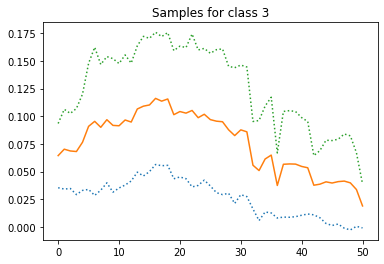

 48%|████▊     | 48000/100000 [1:24:37<1:36:06,  9.02it/s]

Iter-48000; D_loss: 0.005594087298959494; G_loss: -0.231859028339386; C_loss: 0.014811849221587181


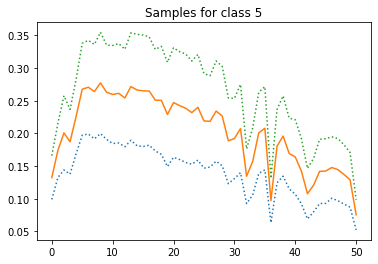

 49%|████▉     | 49000/100000 [1:26:22<1:39:46,  8.52it/s]

Iter-49000; D_loss: -0.0031413091346621513; G_loss: -0.23109552264213562; C_loss: 0.012293498031795025


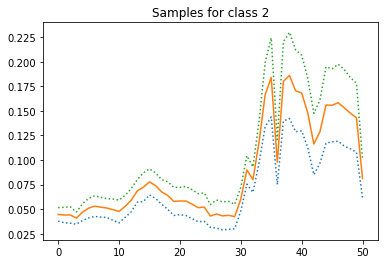

 50%|█████     | 50000/100000 [1:28:09<1:28:14,  9.44it/s]

Iter-50000; D_loss: -0.0015262030065059662; G_loss: -0.23942992091178894; C_loss: 0.012279069051146507


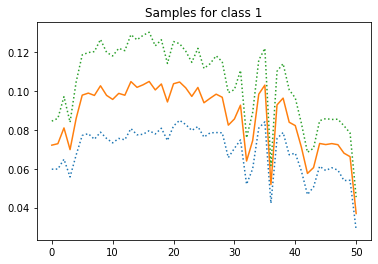

 51%|█████     | 50999/100000 [1:29:55<1:36:17,  8.48it/s]

Iter-51000; D_loss: 0.0005900675896555185; G_loss: -0.23944897949695587; C_loss: 0.010451298207044601


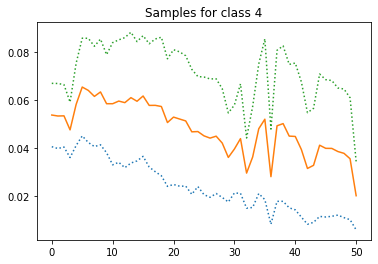

 52%|█████▏    | 51999/100000 [1:31:39<1:28:12,  9.07it/s]

Iter-52000; D_loss: -0.007330137304961681; G_loss: -0.24268433451652527; C_loss: 0.019228432327508926


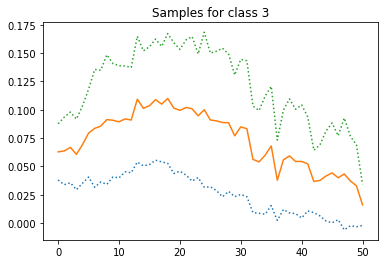

 53%|█████▎    | 53000/100000 [1:33:25<1:20:34,  9.72it/s]

Iter-53000; D_loss: -0.0021618681494146585; G_loss: -0.24701331555843353; C_loss: 0.008764535188674927


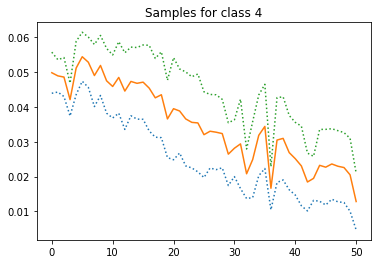

 54%|█████▍    | 54000/100000 [1:35:12<1:21:16,  9.43it/s]

Iter-54000; D_loss: 0.00048427609726786613; G_loss: -0.25004130601882935; C_loss: 0.013356955721974373


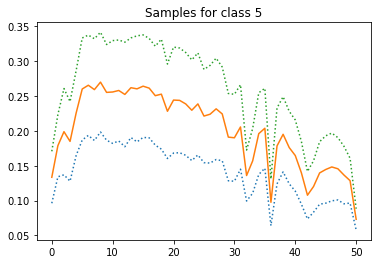

 55%|█████▌    | 55000/100000 [1:36:57<1:23:04,  9.03it/s]

Iter-55000; D_loss: -0.000838259351439774; G_loss: -0.259071946144104; C_loss: 0.011857653968036175


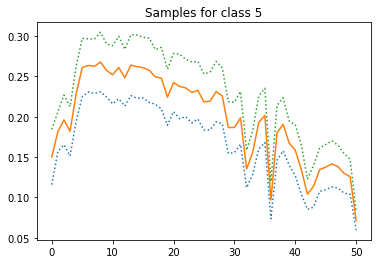

 56%|█████▌    | 56000/100000 [1:38:43<1:16:32,  9.58it/s]

Iter-56000; D_loss: -0.003732213517650962; G_loss: -0.26071956753730774; C_loss: 0.00895778089761734


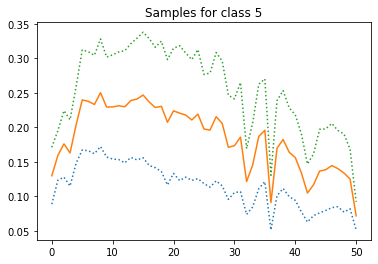

 57%|█████▋    | 57000/100000 [1:40:28<1:18:13,  9.16it/s]

Iter-57000; D_loss: 0.0002748535480350256; G_loss: -0.25633299350738525; C_loss: 0.013538488186895847


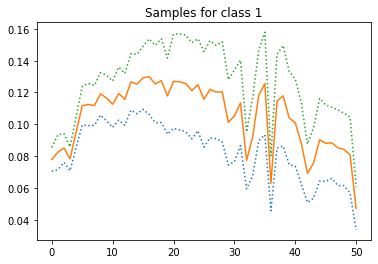

 58%|█████▊    | 57999/100000 [1:42:14<1:12:43,  9.62it/s]

Iter-58000; D_loss: -0.0020575448870658875; G_loss: -0.2598626911640167; C_loss: 0.01127807516604662


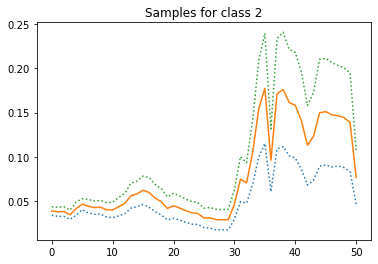

 59%|█████▉    | 58999/100000 [1:44:00<1:07:53, 10.06it/s]

Iter-59000; D_loss: -0.0010940898209810257; G_loss: -0.2710917592048645; C_loss: 0.009688747115433216


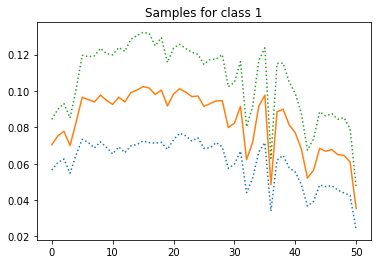

 60%|██████    | 60000/100000 [1:45:47<1:06:35, 10.01it/s]

Iter-60000; D_loss: -0.0023954142816364765; G_loss: -0.27279341220855713; C_loss: 0.0093074394389987


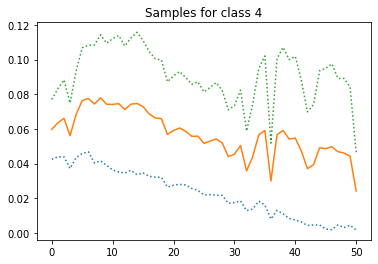

 61%|██████    | 60999/100000 [1:47:32<1:08:14,  9.52it/s]

Iter-61000; D_loss: -3.8346974179148674e-05; G_loss: -0.26480159163475037; C_loss: 0.012555146589875221


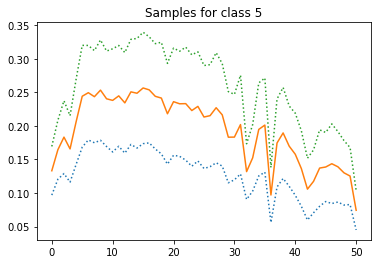

 62%|██████▏   | 62000/100000 [1:49:18<1:10:26,  8.99it/s]

Iter-62000; D_loss: -0.0034889262169599533; G_loss: -0.2723425328731537; C_loss: 0.011382791213691235


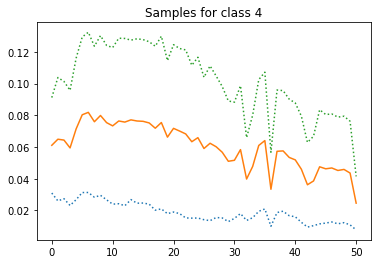

 63%|██████▎   | 63000/100000 [1:51:05<1:08:40,  8.98it/s]

Iter-63000; D_loss: -0.0006285810377448797; G_loss: -0.27055656909942627; C_loss: 0.009603086858987808


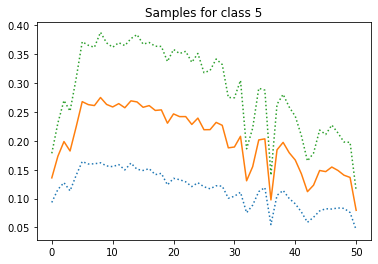

 64%|██████▍   | 64000/100000 [1:52:51<1:07:08,  8.94it/s]

Iter-64000; D_loss: -0.0016734732780605555; G_loss: -0.27148759365081787; C_loss: 0.008264904841780663


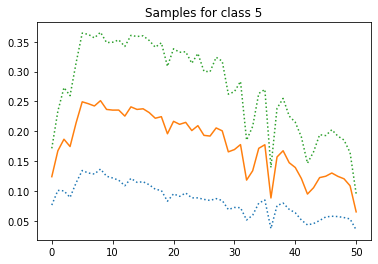

 65%|██████▍   | 64999/100000 [1:54:37<57:21, 10.17it/s]  

Iter-65000; D_loss: -0.00031117768958210945; G_loss: -0.2842724919319153; C_loss: 0.0069527397863566875


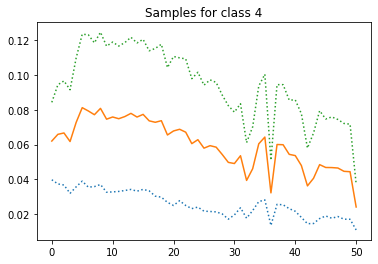

 66%|██████▌   | 65999/100000 [1:56:23<59:47,  9.48it/s]  

Iter-66000; D_loss: -0.003814801573753357; G_loss: -0.27912309765815735; C_loss: 0.01505226455628872


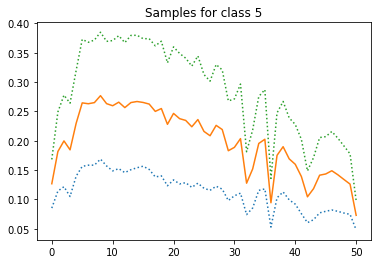

 67%|██████▋   | 67000/100000 [1:58:10<57:42,  9.53it/s]  

Iter-67000; D_loss: -0.0016392230754718184; G_loss: -0.28380608558654785; C_loss: 0.01003603171557188


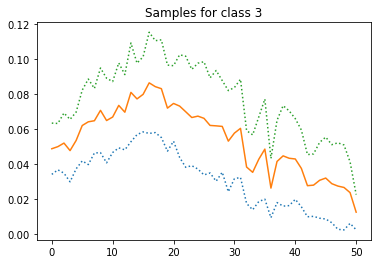

 68%|██████▊   | 68000/100000 [1:59:56<55:15,  9.65it/s]  

Iter-68000; D_loss: -0.0008143525337800384; G_loss: -0.2883298397064209; C_loss: 0.009602964855730534


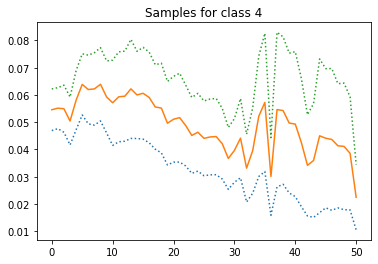

 69%|██████▉   | 69000/100000 [2:01:43<53:33,  9.65it/s]  

Iter-69000; D_loss: 0.0002305852249264717; G_loss: -0.2912864089012146; C_loss: 0.007500472012907267


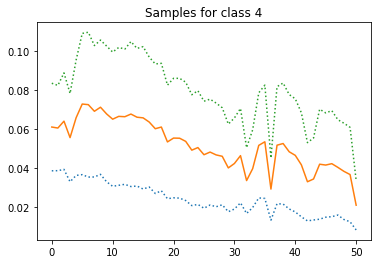

 70%|███████   | 70000/100000 [2:03:30<50:46,  9.85it/s]  

Iter-70000; D_loss: -0.0013322198064997792; G_loss: -0.2897733449935913; C_loss: 0.014375481754541397


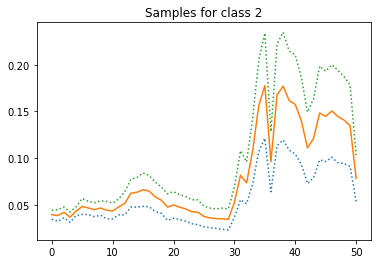

 71%|███████   | 71000/100000 [2:05:17<49:40,  9.73it/s]  

Iter-71000; D_loss: -0.0027674275916069746; G_loss: -0.2944244146347046; C_loss: 0.008143524639308453


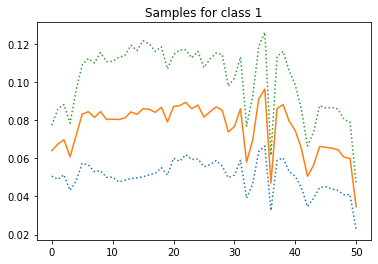

 72%|███████▏  | 72000/100000 [2:07:06<50:36,  9.22it/s]  

Iter-72000; D_loss: -0.002376784570515156; G_loss: -0.29840028285980225; C_loss: 0.007889743894338608


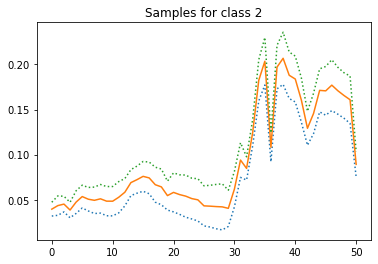

 73%|███████▎  | 72999/100000 [2:08:53<48:34,  9.26it/s]  

Iter-73000; D_loss: -0.0008310041157528758; G_loss: -0.2990540862083435; C_loss: 0.006958119571208954


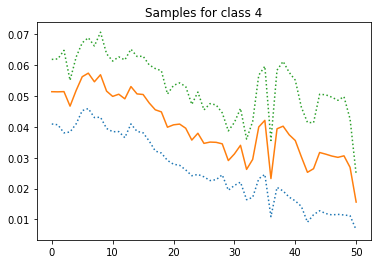

 74%|███████▍  | 74000/100000 [2:10:40<45:47,  9.46it/s]

Iter-74000; D_loss: -0.0011349241249263287; G_loss: -0.29726654291152954; C_loss: 0.009497305378317833


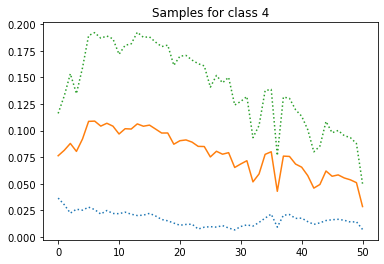

 75%|███████▌  | 75000/100000 [2:12:27<46:37,  8.94it/s]

Iter-75000; D_loss: -0.0060857972130179405; G_loss: -0.2953749895095825; C_loss: 0.01324226800352335


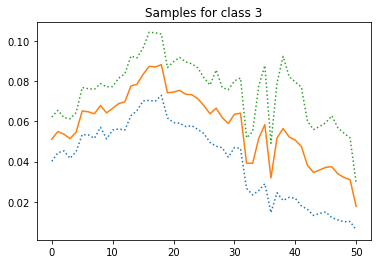

 76%|███████▌  | 76000/100000 [2:14:12<44:20,  9.02it/s]

Iter-76000; D_loss: -0.0025477155577391386; G_loss: -0.3081572651863098; C_loss: 0.004943533334881067


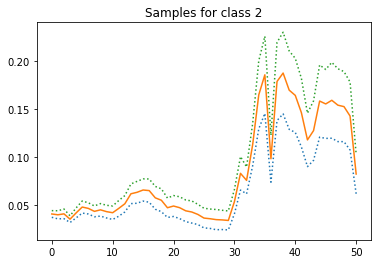

 77%|███████▋  | 77000/100000 [2:15:58<39:13,  9.77it/s]  

Iter-77000; D_loss: -0.006661371793597937; G_loss: -0.30371519923210144; C_loss: 0.011257070116698742


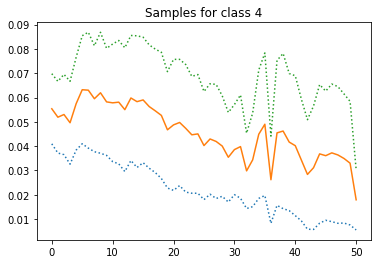

 78%|███████▊  | 78000/100000 [2:17:46<41:49,  8.77it/s]

Iter-78000; D_loss: 0.0006817523390054703; G_loss: -0.30485033988952637; C_loss: 0.0074105337262153625


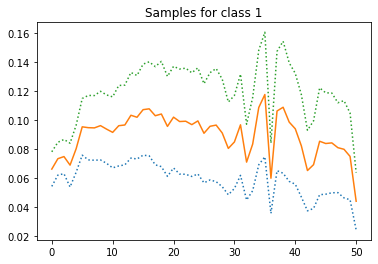

 79%|███████▉  | 79000/100000 [2:19:34<40:27,  8.65it/s]

Iter-79000; D_loss: -0.0008200980955734849; G_loss: -0.3028322458267212; C_loss: 0.008384490385651588


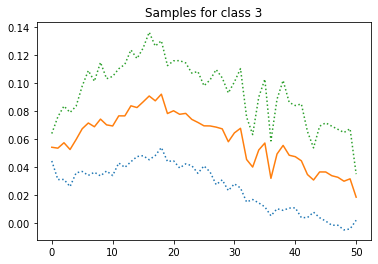

 80%|███████▉  | 79999/100000 [2:21:20<34:12,  9.74it/s]

Iter-80000; D_loss: -0.0004939092323184013; G_loss: -0.30391085147857666; C_loss: 0.007161319721490145


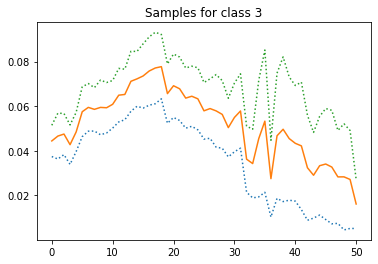

 81%|████████  | 81000/100000 [2:23:07<31:08, 10.17it/s]

Iter-81000; D_loss: -0.0024666469544172287; G_loss: -0.2999033033847809; C_loss: 0.005758505780249834


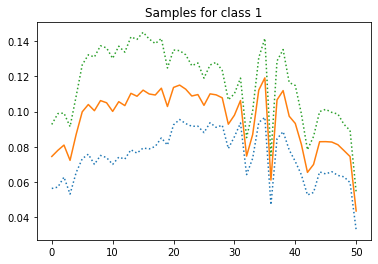

c:\Users\nang\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 82%|████████▏ | 82000/100000 [2:24:53<30:04,  9.97it/s]

Iter-82000; D_loss: -0.0002652199473232031; G_loss: -0.30601805448532104; C_loss: 0.0066580092534422874


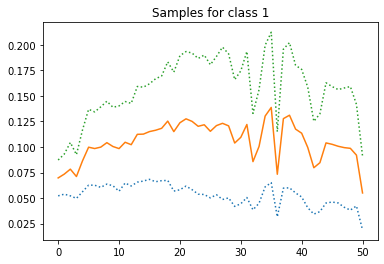

 83%|████████▎ | 83000/100000 [2:26:40<29:56,  9.46it/s]

Iter-83000; D_loss: -0.002075027907267213; G_loss: -0.3086121678352356; C_loss: 0.008091558702290058


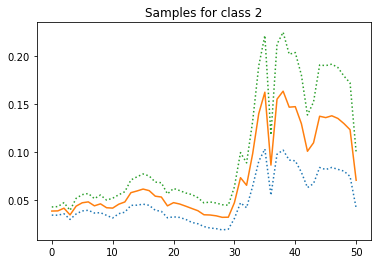

 84%|████████▍ | 84000/100000 [2:28:26<28:34,  9.33it/s]

Iter-84000; D_loss: -0.002157359616830945; G_loss: -0.3101887106895447; C_loss: 0.00959253404289484


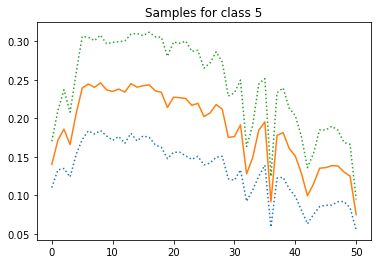

 85%|████████▌ | 85000/100000 [2:30:12<27:33,  9.07it/s]

Iter-85000; D_loss: -0.004746418911963701; G_loss: -0.31100940704345703; C_loss: 0.006983201019465923


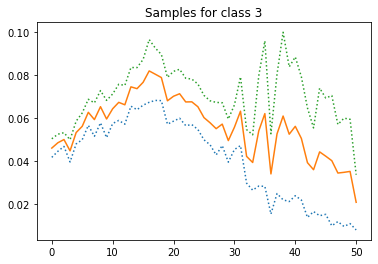

 86%|████████▌ | 86000/100000 [2:31:58<23:08, 10.08it/s]

Iter-86000; D_loss: 9.455904364585876e-05; G_loss: -0.3135458827018738; C_loss: 0.0066260709427297115


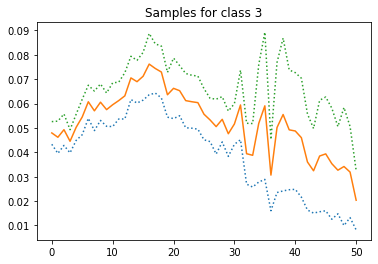

 87%|████████▋ | 87000/100000 [2:33:45<21:47,  9.94it/s]

Iter-87000; D_loss: -0.0002918523969128728; G_loss: -0.3158750534057617; C_loss: 0.0110016455873847


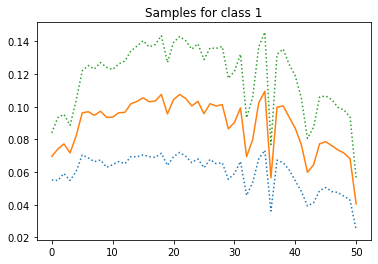

 88%|████████▊ | 88000/100000 [2:35:33<22:03,  9.07it/s]

Iter-88000; D_loss: -0.001455093501135707; G_loss: -0.318717360496521; C_loss: 0.007125852629542351


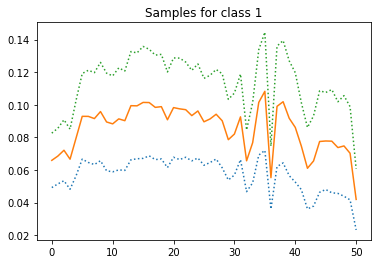

 89%|████████▉ | 89000/100000 [2:37:19<18:56,  9.68it/s]

Iter-89000; D_loss: -0.0017763003706932068; G_loss: -0.31667211651802063; C_loss: 0.0059356349520385265


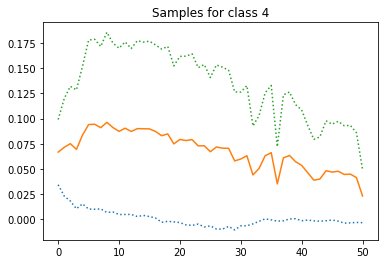

 90%|█████████ | 90000/100000 [2:39:07<18:10,  9.17it/s]

Iter-90000; D_loss: -0.0026609189808368683; G_loss: -0.32106444239616394; C_loss: 0.006028711795806885


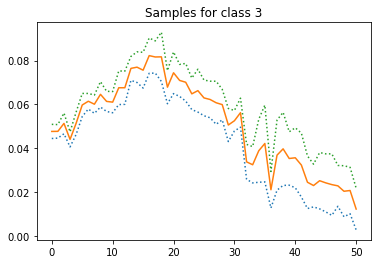

 91%|█████████ | 91000/100000 [2:40:52<15:42,  9.55it/s]

Iter-91000; D_loss: -0.0016669093165546656; G_loss: -0.32379424571990967; C_loss: 0.006198509130626917


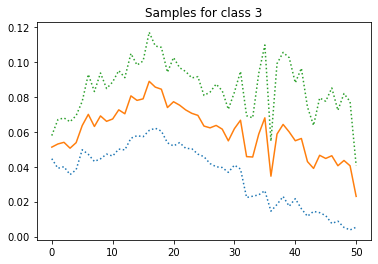

 92%|█████████▏| 92000/100000 [2:42:39<14:08,  9.43it/s]

Iter-92000; D_loss: -0.002433593850582838; G_loss: -0.32902735471725464; C_loss: 0.005394721403717995


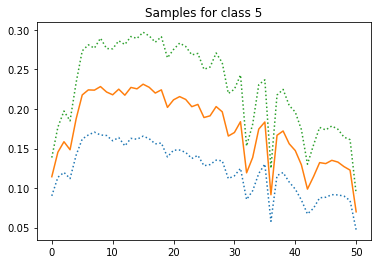

 93%|█████████▎| 93000/100000 [2:44:26<12:38,  9.23it/s]

Iter-93000; D_loss: -0.006530423182994127; G_loss: -0.32617464661598206; C_loss: 0.008066446520388126


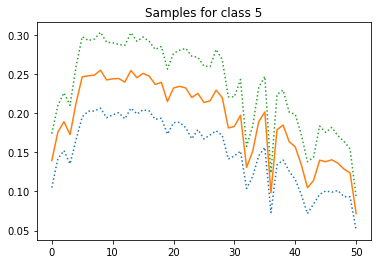

 94%|█████████▍| 94000/100000 [2:46:13<10:55,  9.16it/s]

Iter-94000; D_loss: -0.0026678224094212055; G_loss: -0.3390507400035858; C_loss: 0.005677599459886551


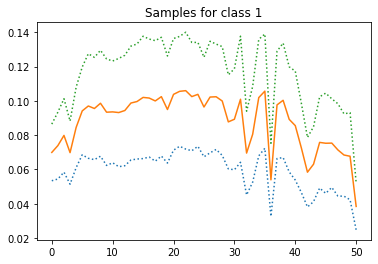

 95%|█████████▌| 95000/100000 [2:47:59<08:14, 10.12it/s]

Iter-95000; D_loss: -1.5477417036890984e-05; G_loss: -0.33617520332336426; C_loss: 0.008480843156576157


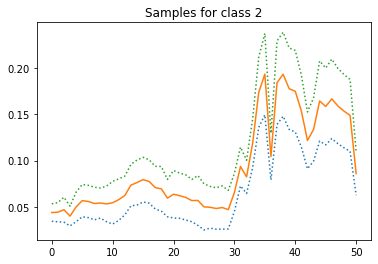

c:\Users\nang\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 96%|█████████▌| 96000/100000 [2:49:46<06:58,  9.57it/s]

Iter-96000; D_loss: 0.002370271598920226; G_loss: -0.3416634798049927; C_loss: 0.00855398178100586


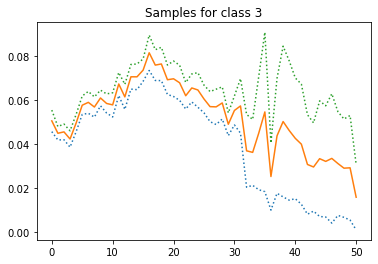

 97%|█████████▋| 96999/100000 [2:51:33<05:26,  9.20it/s]

Iter-97000; D_loss: -0.00057653384283185; G_loss: -0.3483979403972626; C_loss: 0.007657254580408335


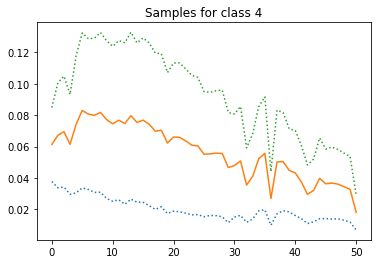

 98%|█████████▊| 97999/100000 [2:53:20<03:48,  8.76it/s]

Iter-98000; D_loss: -0.002842523856088519; G_loss: -0.3483692705631256; C_loss: 0.009963415563106537


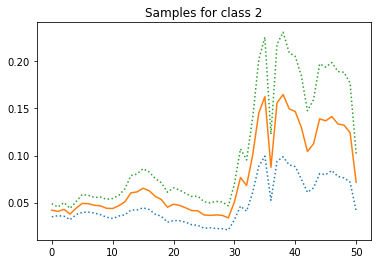

 99%|█████████▉| 99000/100000 [2:55:06<01:40,  9.95it/s]

Iter-99000; D_loss: -0.00026015867479145527; G_loss: -0.3574272692203522; C_loss: 0.006727092899382114


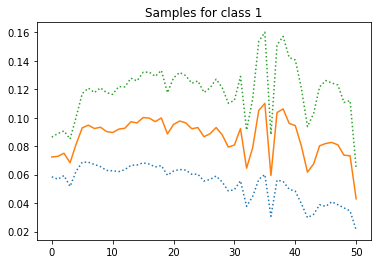

100%|██████████| 100000/100000 [2:56:53<00:00,  9.42it/s]


In [52]:
# Get networks
G = Generator().cuda()
D = Discriminator().cuda()
C = Classifier().cuda()

# Use RMSProp optimizer
G_solver = optim.RMSprop(G.parameters(), lr=lr)
D_solver = optim.RMSprop(D.parameters(), lr=lr)
C_solver = optim.RMSprop(C.parameters(), lr=lr)

for it in tqdm(range(100000)):
    ###########################
    # (1) Update C and D      #
    ###########################
    for p in D.parameters():  # reset requires_grad
        p.requires_grad = True  # they are set to False below in netG update
    for p in C.parameters():
        p.requires_grad = True
    
    # D is trained d_step times for each iteration
    
    for _, (X, y), (X_, y_) in zip(range(d_step), data_loader, data_loader):
        D.zero_grad()

        # Sample random noise
        z = torch.randn(y.size(0), z_dim).squeeze()
        X, y = X.float(), y.float()
        X_, y_ = X_.float(), y_.float()
        # Mixup
        lam = np.random.beta(mixup_alpha, mixup_alpha)
        X = lam*X + (1. - lam)*X_
        X, y, z = X.cuda(), y.cuda(), z.cuda()
        y_ = y_.cuda()
        
        # Get discriminator prediction on real samples
        D_real = D(X).mean()
        # Get discriminator prediction on fake samples
        fake_samples = G(z, y)
        D_fake = D(fake_samples).mean()
        # Compute gradient penalty
        gradient_penalty = calc_gradient_penalty(D, X.data, fake_samples.data)
        # Compute loss and backpropagate
        D_loss = D_fake - D_real + gradient_penalty
        flip = np.random.random() < flip_percentage
        if flip: 
            # Flip real and fake
            gradient_penalty = calc_gradient_penalty(D, fake_samples.data, X.data)
            D_loss = D_real - D_fake + gradient_penalty
        D_loss.backward()
        D_solver.step()
    
        ######################
        #  Update C network  #
        ######################
        C.zero_grad()
        # Get class values
        _, classes = torch.max(y, dim=1)
        _, classes_ = torch.max(y_, dim=1)
        # Get predictions from C
        if flip:
            fake_samples = G(z, y)
            pred = C(fake_samples)
            # Compute loss and backpropagate
            C_loss = F.cross_entropy(pred, classes, weight=class_weights)
        else:
            pred = F.log_softmax(C(X))
            C_loss = lam * F.nll_loss(pred, classes) + (1. - lam) * F.nll_loss(pred, classes_)
        C_loss.backward()
        C_solver.step()


    ############################
    # (2) Update G network
    ###########################
    for p in D.parameters():
        p.requires_grad = False  # to avoid computation
    for p in C.parameters():
        p.requires_grad = False
    reset_grad(C, G, D)

    # Sample random noise
    z = torch.randn(y.size(0), z_dim).squeeze()
    z = z.cuda()
    # Generate fake samples
    G_sample = G(z, y)
    D_fake = D(G_sample)
    pred = C(G_sample)
    C_loss = F.cross_entropy(pred, classes, weight=class_weights)
    # Fool the discriminator (WGAN)
    G_loss = -torch.mean(D_fake)
    # Include the auxialiary classifier loss (AC-GAN)
    loss = G_loss + c_weight * C_loss
    # Backpropagate
    loss.backward()
    G_solver.step()

    # Print and plot every now and then
    if it % 1000 == 0:
        with torch.no_grad():
            print('Iter-{}; D_loss: {}; G_loss: {}; C_loss: {}'.format(it,
                                                           D_loss.data.cpu().numpy(), G_loss.data.cpu().numpy(),
                                                           C_loss.data.cpu().numpy()))
            z = torch.randn(mb_size, z_dim).squeeze().cuda()
            c = np.zeros(shape=[mb_size, c_dim], dtype='float32')
            idx = np.random.randint(1, data_loader.dataset.n_classes)
            c[:, idx] = 1.
            c = torch.from_numpy(c).squeeze().cuda()
            samples = G(z, c).data.cpu().numpy()[:16]
            pred = G(z, c)
            plot_mean_std(samples)
            plt.title("Samples for class {}".format(idx))
            plt.show()

## Data generation

Now that the generator has been trained, we can generate some fake spectra and see how they fare visually against the real ones.

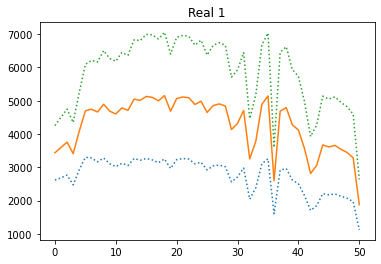

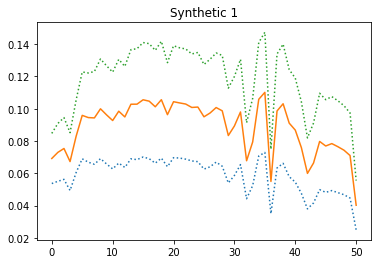

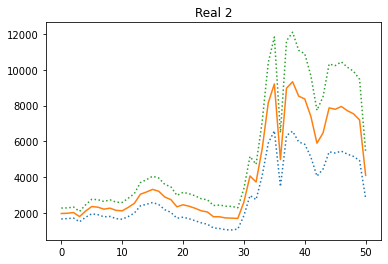

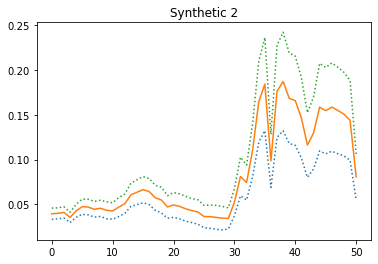

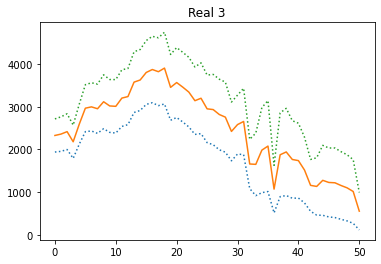

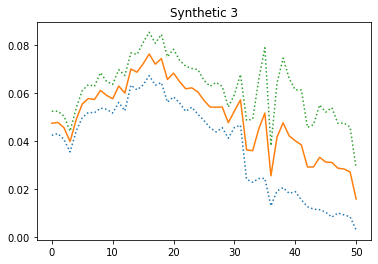

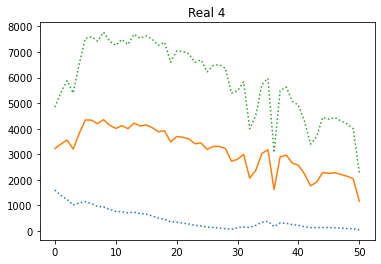

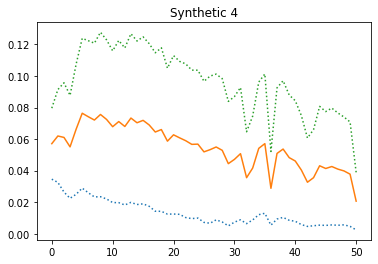

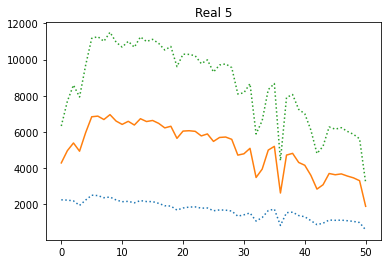

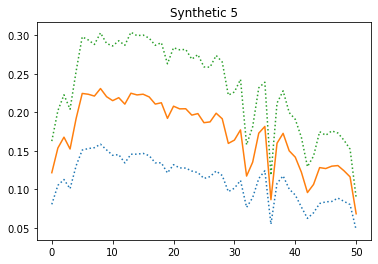

In [53]:
for c in np.unique(gt):
    # 0 is the "undefined" class
    if c == 0:
        continue
    
    # Get the mean spectrum +- std for this class
    spectras = img[gt == c, :]
    plot_mean_std(spectras)
    plt.title("Real {}".format(c))
    plt.show()
    
    # Get as many fake spectras as real ones
    synthetic_spectras = []
    with torch.no_grad():
        while len(synthetic_spectras) < len(spectras):
            z = torch.randn(mb_size, z_dim).cuda()
            y = torch.from_numpy(np.eye(data_loader.dataset.n_classes)[c]).float()
            y = y.unsqueeze(0).repeat(mb_size, 1).cuda()
            G_sample = G(z, y)
            _, classes = torch.max(y, 1)
            _, pred = torch.max(C(G_sample), 1)
            synthetic_spectras += list(G_sample.cpu().data.numpy())
    plt.show()
    plot_mean_std(synthetic_spectras)
    plt.title("Synthetic {}".format(c))
    plt.show()

In [55]:
generated_img = np.array(img.shape)
channels    =  np.array([])
counts = np.asarray(np.unique(gt,return_counts=True))[1]

for channel_label in np.unique(gt):
    
    generate_size = counts[channel_label]
    z = torch.randn(generate_size, z_dim).cuda()
    y = torch.from_numpy(np.eye(data_loader.dataset.n_classes)[channel_label]).float()
    y = y.unsqueeze(0).repeat(generate_size, 1).cuda()
    G_sample = G(z, y)
    # print(channel_label, generate_size, G_sample)


RuntimeError: CUDA out of memory. Tried to allocate 480.00 MiB (GPU 0; 4.00 GiB total capacity; 2.51 GiB already allocated; 79.25 MiB free; 2.53 GiB reserved in total by PyTorch)

In [ ]:
print(data_loader.dataset.n_classes)

for channel_label in np.unique(gt):
    z = torch.randn(mb_size, z_dim).cuda()
    y = torch.from_numpy(np.eye(data_loader.dataset.n_classes)[channel_label]).float()
    y = y.unsqueeze(0).repeat(mb_size, 1).cuda()
    G_sample = G(z, y)
    # print(G_sample)
    # print(np.shape(z),np.shape(y))
    

10
tensor([[0.2315, 0.2378, 0.2395,  ..., 0.2966, 0.3008, 0.2993],
        [0.1961, 0.1649, 0.1669,  ..., 0.4066, 0.4054, 0.4088],
        [0.2364, 0.2335, 0.2097,  ..., 0.3213, 0.3278, 0.3306],
        ...,
        [0.2366, 0.2081, 0.1742,  ..., 0.3488, 0.3518, 0.3568],
        [0.2014, 0.1844, 0.1709,  ..., 0.3077, 0.3124, 0.3132],
        [0.1937, 0.1723, 0.1699,  ..., 0.3350, 0.3382, 0.3436]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.1136, 0.1145, 0.1077,  ..., 0.1583, 0.1622, 0.1647],
        [0.1878, 0.2072, 0.2050,  ..., 0.1909, 0.1970, 0.1934],
        [0.1512, 0.1692, 0.1614,  ..., 0.2010, 0.2011, 0.1979],
        ...,
        [0.1357, 0.1400, 0.1451,  ..., 0.1515, 0.1558, 0.1558],
        [0.0994, 0.1013, 0.1040,  ..., 0.1737, 0.1773, 0.1838],
        [0.1762, 0.1844, 0.1797,  ..., 0.1953, 0.2002, 0.2029]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.1057, 0.1138, 0.0722,  ..., 0.2414, 0.2493, 0.2446],
        [0.1114, 0.0883, 0.0548,  .

### SVM on fake data

We now generate some fake data (in the same quantities as the real data) and apply the trained SVM on it.

In [ ]:
def gan_create_fake_dataset(labels):
    with torch.no_grad():
        spectras = []
        for l in np.array_split(labels, len(labels) // mb_size):
            
            z = torch.randn(len(l), z_dim).cuda()
            y = np.zeros((len(l), data_loader.dataset.n_classes))
            for i, label in enumerate(l):
                y[i] = np.eye(data_loader.dataset.n_classes)[label]
            y = torch.from_numpy(y).float()
            eps = torch.randn(y.size())/10
            #y += eps
            y = y.cuda()
            G_sample = G(z, y)
            spectras += list(G_sample.cpu().data.numpy())
        return np.array(spectras), np.array(labels)

In [ ]:

# (unique, counts) = np.unique(gt, return_counts=True)
# frequencies = np.asarray((unique, counts)).T
# print(frequencies)

In [ ]:
from PIL import Image
_gt = np.array([gt[x,y] for x,y in zip(*np.nonzero(gt))])
_axis_x = np.array([x for x,y in zip(*np.nonzero(gt))])
_axis_y = np.array([y for x,y in zip(*np.nonzero(gt))])
out_pixels, out_gt_img = gan_create_fake_dataset(_gt)
input_width = np.shape(img)[0]
input_height = np.shape(img)[1]

# test_img = np.reshape(out_img,(input_width,-1,X_dim) )
# print(np.shape(test_img))

out_img = np.copy(img)
for i in range(len(_gt)):
    x = _axis_x[i]
    y = _axis_y[i]
    if gt[x][y] > 0:
        out_img[x][y] = out_pixels[i]
print(np.shape(_gt))
print(np.shape(img))
print(np.shape(out_img))
print(np.shape(out_gt_img))


(42776,)
(610, 340, 103)
(610, 340, 103)
(42776,)


In [ ]:
# print(out_pixels[out_pixels > 1])

[]


In [ ]:
import scipy.io as sio
import matplotlib

# matplotlib.image.imsave("./output_images/out_img.tif", out_img)
# im = Image.new('L', (input_width, input_height))
# im.putdata(out_img.flatten().tolist())
# im.save("filename.tiff", format="TIFF", save_all=True)
out_rgb = out_img[:,:,(55,41,12)]

matplotlib.image.imsave("./output_images/out_rgb.png", out_rgb)


savedict = {
    'paviaU_out' : out_img,
}
sio.savemat('./output_images/out_img.mat', savedict)

#out_gt_img = Image.fromarray(out_gt_img)
#out_img.save("./output_images/out_img.tif")
#out_gt_img.save("./output_images/out_gt_img.png")